In [1]:
import numpy as np
from matplotlib import pyplot as plt
from Plots import plot_multiple_epochs
from Utils import *
import multiprocess as mp
import ctypes

## Generate the synthetic data

In [3]:
ratings_df, long_df, meta = generate_synthetic_ratings(
    n_users=100,
    n_items=50,
    n_factors=6,
    n_groups=5,
    group_strength=0.1,
    user_noise=0.1,
    item_scale=0.1,
    user_bias_std=0.0,
    item_bias_std=0.0,
    global_mean=0.0,
    noise_std=0.05,
    rating_min=None,
    rating_max=None,
    random_seed=0
)

ratings_df = inject_nans(ratings_df, 0.6, 0)

print("Generated matrix shape:", ratings_df.shape)

ratings_df

Generated matrix shape: (100, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.394674,NaN,NaN,NaN,-0.227542,0.033453,-0.211666,-0.041365,NaN,-0.410358,...,NaN,NaN,NaN,NaN,NaN,-0.091771,NaN,-0.152258,NaN,-0.369670
1,-0.281981,NaN,-0.517305,NaN,NaN,NaN,NaN,0.400930,NaN,NaN,...,0.156050,-0.143617,NaN,0.388701,0.135379,-0.325975,NaN,-0.126219,0.015961,-0.086175
2,NaN,NaN,-0.542684,0.365954,NaN,NaN,NaN,0.305038,NaN,-0.326129,...,NaN,NaN,-0.047419,NaN,NaN,-0.284699,NaN,-0.135756,NaN,-0.152931
3,NaN,NaN,NaN,-0.005354,NaN,-0.017659,0.005187,NaN,0.014036,NaN,...,NaN,NaN,NaN,NaN,-0.265783,NaN,NaN,0.046497,-0.182657,NaN
4,NaN,NaN,-0.631196,NaN,NaN,0.615980,0.230264,NaN,NaN,-0.301161,...,NaN,-0.347528,-0.075689,NaN,0.084483,-0.225688,-0.067207,-0.125369,NaN,-0.049960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.217740,NaN,NaN,0.300119,-0.773184,0.530891,NaN,0.316591,-0.241072,NaN,...,NaN,-0.284445,-0.010974,NaN,NaN,NaN,NaN,-0.169910,NaN,-0.081071
96,-0.386010,NaN,0.248895,NaN,-0.131339,-0.031423,NaN,NaN,NaN,NaN,...,-0.148696,NaN,NaN,NaN,NaN,0.004973,-0.062604,NaN,0.322216,NaN
97,-0.127307,0.455464,NaN,0.311222,-0.712594,NaN,0.163919,0.373270,NaN,NaN,...,NaN,NaN,-0.081977,NaN,NaN,NaN,-0.223310,NaN,-0.051357,-0.156935
98,NaN,-0.006601,0.173605,NaN,0.217927,NaN,NaN,NaN,0.054877,0.145589,...,NaN,NaN,0.036908,NaN,NaN,NaN,NaN,NaN,NaN,0.048370


In [ ]:
real_grade = ratings_df.iloc[0, -1]
ratings_att = inject_attackers(ratings_df, nb_attackers=10, att_grade=100000)

In [ ]:
ratings_att

In [ ]:
real_grade

## Compute the delta and the error for a certain reg and nb of attackers

In [ ]:
nb_attackers_to_test = np.arange(0, 5, 1)

user_sim = create_sim(ratings_df.iloc[0], ratings_df.drop(0))

sane_pred = pipeline_mean(ratings_df, user_sim, 0, -1)
error = np.abs(real_grade - sane_pred)

delts = np.array([])
for idx, j in enumerate(nb_attackers_to_test):

    delt = compute_delta(ratings_df, nb_attackers=j, algo='mean')
    delts = np.append(delts, delt)

print(delts)
plt.hlines(error, nb_attackers_to_test[0], nb_attackers_to_test[-1], label='error', color='blue')
plt.plot(nb_attackers_to_test, delts, label='delta', color='red')
plt.xlabel('nb attackers')
plt.legend()

plt.show()

In [ ]:
print(error)

KeyboardInterrupt: 

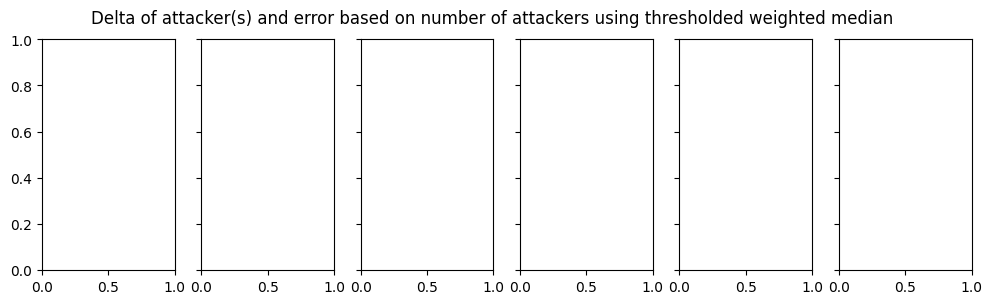

In [11]:

nb_attackers_to_test = np.arange(0, 6, 1)
thresholds = np.arange(0, 0.7, 0.2)

fig, axs = plt.subplots(1, len(nb_attackers_to_test), figsize=(2*len(nb_attackers_to_test), 3), sharex='all', sharey='all')
fig.suptitle('Delta of attacker(s) and error based on number of attackers using thresholded weighted median')

plot_for_nbattackers_thresh_reg(axs, nb_attackers_to_test, thresholds, 8, 1.96, 'median')

In [ ]:
regs = np.arange(0, 5, 1)
nb_attackers_to_test = np.arange(0, 6, 1)


fig, axs = plt.subplots(1, len(nb_attackers_to_test), figsize=(2*len(nb_attackers_to_test), 3), sharex='all', sharey='all')
fig.suptitle('Delta of attacker(s) and error based on number of attackers using regularizer of qrmed')

plot_for_nbattackers_thresh_reg(axs, nb_attackers_to_test, regs, 8, 1.96, 'qrmed')

When the threshold increase, the delta increase as well => if the user's group rates an object -1, another group rates 1 and the adversary 1000, the non-thresholded version would still predict -1 since a lot of people are in this group. But if we increase the threshold, the other group gain weight and the prediction can change group because of the adversary.

In [ ]:
reg_to_test = np.arange(0.0, 40.0, 5.0)
#reg_to_test = np.array([0.1, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6])
nb_attackers_to_test = np.arange(1, 7, 1)

fig, axs = plt.subplots(1, len(nb_attackers_to_test), figsize=(2*len(nb_attackers_to_test), 3), sharex='all', sharey='all')

errors = np.array([])
user_sim = create_sim(ratings_df.iloc[0], ratings_df.drop(0))

for i in reg_to_test:
    sane_pred = pipeline_qrw_med(ratings_df, user_sim, 0, -1, reg=i)
    errors = np.append(errors, np.abs(real_grade - sane_pred))


for idx, j in enumerate(nb_attackers_to_test):
    delts = np.array([])
    for i in reg_to_test:
        delt = compute_delta(ratings_df, reg=i, nb_attackers=j)
        delts = np.append(delts, delt)


    axs[idx].set_title(j)
    axs[idx].set_xlabel('Reg')
    axs[idx].plot(reg_to_test, errors, label='error', color='blue')
    axs[idx].plot(reg_to_test, delts, label='delta', color='red')
    axs[idx].legend()

axs[0].set_ylabel('Delta/Error')
plt.title('Delta of attacker(s) and error based on number of attackers and using QrwMed')
plt.show()


## Edge case: Nobody voted for the item

In [ ]:
ratings_df_edge: pd.DataFrame = ratings_df.copy()
ratings_df_edge.iloc[:, -1] = np.nan
ratings_df_edge

In [ ]:
nb_attackers_to_test = np.arange(1, 7, 1)
thresholds = np.arange(0, 1.1, 0.2)

fig, axs = plt.subplots(1, len(nb_attackers_to_test), figsize=(2*len(nb_attackers_to_test), 3), sharex='all', sharey='all')
fig.suptitle('Delta of attacker(s) and error based on number of attackers using thresholded weighted median')

errors = np.array([])
user_sim = create_sim(ratings_df_edge.iloc[0], ratings_df_edge.drop(0))

for i in thresholds:
    sane_pred = pipeline_median(ratings_df_edge, user_sim, 0, -1, lower_threshold=i)
    errors = np.append(errors, np.abs(real_grade - sane_pred))


for idx, j in enumerate(nb_attackers_to_test):
    delts = np.array([])

    for i in thresholds:
        delt = compute_delta(ratings_df_edge, nb_attackers=j, algo='median', lower_threshold=i)
        delts = np.append(delts, delt)

    axs[idx].set_title(j)
    axs[idx].set_xlabel('Threshold')
    axs[idx].plot(thresholds, errors, label='error', color='blue')
    axs[idx].plot(thresholds, delts, label='delta', color='red')
    axs[idx].legend()

plt.show()

In [ ]:
reg_to_test = np.arange(1, 20, 2.0)
#reg_to_test = np.array([0.1, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6])
nb_attackers_to_test = np.arange(1, 7, 1)

fig, axs = plt.subplots(1, len(nb_attackers_to_test), figsize=(2*len(nb_attackers_to_test), 3), sharex='all', sharey='all')
fig.suptitle('Delta of attacker(s) and error based on number of attackers and using QrwMed')


errors = np.array([])
user_sim = create_sim(ratings_df_edge.iloc[0], ratings_df_edge.drop(0))

for i in reg_to_test:

    sane_pred = pipeline_qrw_med(ratings_df_edge, user_sim, 0, -1, reg=i)
    errors = np.append(errors, np.abs(real_grade - sane_pred))


for idx, j in enumerate(nb_attackers_to_test):
    delts = np.array([])
    for i in reg_to_test:
        delt = compute_delta(ratings_df_edge, reg=i, nb_attackers=j)
        delts = np.append(delts, delt)


    axs[idx].set_title(j)
    axs[idx].set_xlabel('Reg')
    axs[idx].plot(reg_to_test, errors, label='error', color='blue')
    axs[idx].plot(reg_to_test, delts, label='delta', color='red')
    axs[idx].legend()

axs[0].set_ylabel('Delta/Error')
plt.show()

Attack: search for 'ideal item' to attack


Metrics: Spearman Footrule, Kendall Tau

Définitions rapport

  0%|          | 0/5 [00:00<?, ?it/s]

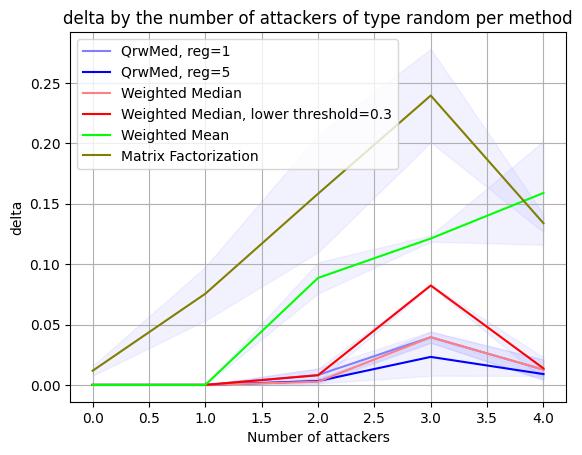

In [3]:
ax = plot_multiple_epochs(n_users=20, n_items=20, missing_prob=0.2, nb_attackers_to_test=np.arange(0, 5, 1), error_func='delta', nb_epochs=2, attackers_algo='random')
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

[0.24009888 0.24009888 0.24009888 0.24009888 0.24009888 0.24009888
 0.24009888 0.24009888 0.24009888 0.24009888]
[0.27571187 0.27571187 0.27571187 0.27571187 0.27571187 0.27571187
 0.27571187 0.27571187 0.27571187 0.27571187]
[0.15204969 0.15204969 0.15204969 0.15204969 0.15204969 0.15204969
 0.15204969 0.15204969 0.15204969 0.15204969]
[0.22749007 0.22749007 0.22749007 0.22749007 0.22749007 0.22749007
 0.22749007 0.22749007 0.22749007 0.22749007]
[0.30912753 0.30912753 0.30912753 0.30912753 0.30912753 0.30912753
 0.30912753 0.30912753 0.30912753 0.30912753]
[0.24009889 0.24009889 0.24009889 0.24009889 0.24009889 0.24009889
 0.24009889 0.24009889 0.24009889 0.24009889]
[0.27571187 0.27571187 0.27571187 0.27571187 0.27571187 0.27571187
 0.27571187 0.27571187 0.27571187 0.27571187]
[0.24009889 0.24009889 0.24009889 0.24009889 0.24009889 0.24009889
 0.24009889 0.24009889 0.24009889 0.24009889]
[0.36543115 0.36543115 0.36543115 0.36543115 0.36543115 0.36543115
 0.36543115 0.36543115 0.3654

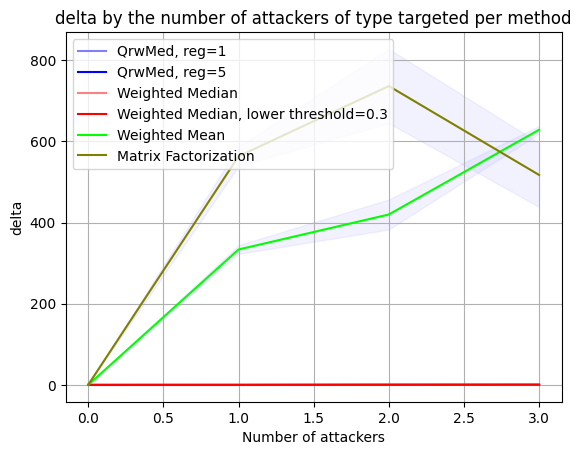

In [2]:
ax = plot_multiple_epochs(n_users=20, n_items=20, missing_prob=0.2, nb_attackers_to_test=np.arange(0, 5, 1), error_func='delta', nb_epochs=2, attackers_algo='targeted')
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

[-0.00337704 -0.00337704 -0.00337704 -0.00337704 -0.00337704 -0.00337704
 -0.00337704 -0.00337704 -0.00337704 -0.00337704]
[0.04120034 0.04120034 0.04120034 0.04120034 0.04120034 0.04120034
 0.04120034 0.04120034 0.04120034 0.04120034]
[0.04120034 0.04120034 0.04120034 0.04120034 0.04120034 0.04120034
 0.04120034 0.04120034 0.04120034 0.04120034]
[0.04120035 0.04120035 0.04120035 0.04120035 0.04120035 0.04120035
 0.04120035 0.04120035 0.04120035 0.04120035]
[0.04120035 0.04120035 0.04120035 0.04120035 0.04120035 0.04120035
 0.04120035 0.04120035 0.04120035 0.04120035]
[-0.00337704 -0.00337704 -0.00337704 -0.00337704 -0.00337704 -0.00337704
 -0.00337704 -0.00337704 -0.00337704 -0.00337704]
[0.06176077 0.06176077 0.06176077 0.06176077 0.06176077 0.06176077
 0.06176077 0.06176077 0.06176077 0.06176077]
[-0.00337703 -0.00337703 -0.00337703 -0.00337703 -0.00337703 -0.00337703
 -0.00337703 -0.00337703 -0.00337703 -0.00337703]
[-0.00337703 -0.00337703 -0.00337703 -0.00337703 -0.00337703 -0.00

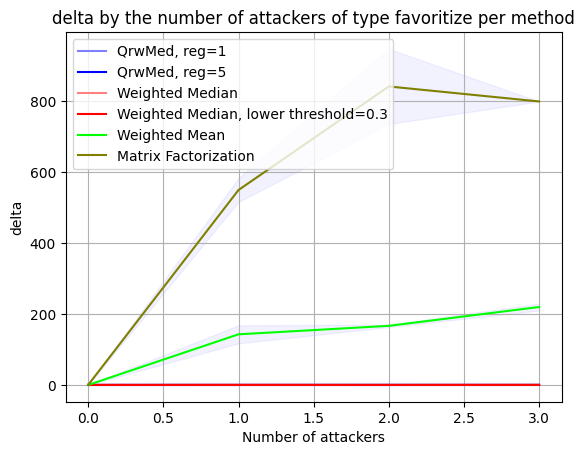

In [3]:
ax = plot_multiple_epochs(n_users=10, n_items=10, missing_prob=0.1, nb_attackers_to_test=np.arange(0, 4, 1), error_func='delta', nb_epochs=2, attackers_algo='favoritize')
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

1.235978000990098
1.6554869288753706
1.2612335004349364
0.7030128345473269
3.7232361081181713
5.333805758526743
4.747777188130483
2.8711455868191087


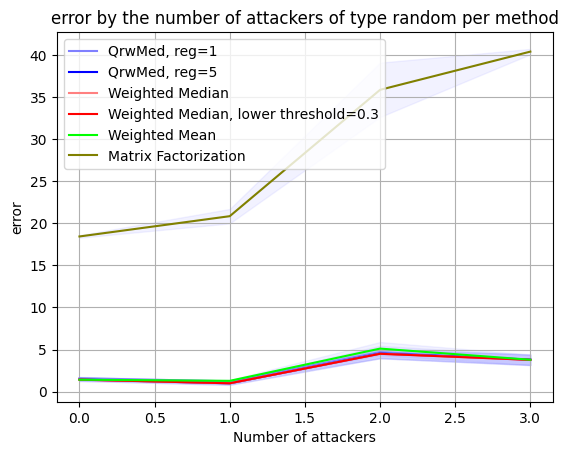

  0%|          | 0/4 [00:00<?, ?it/s]

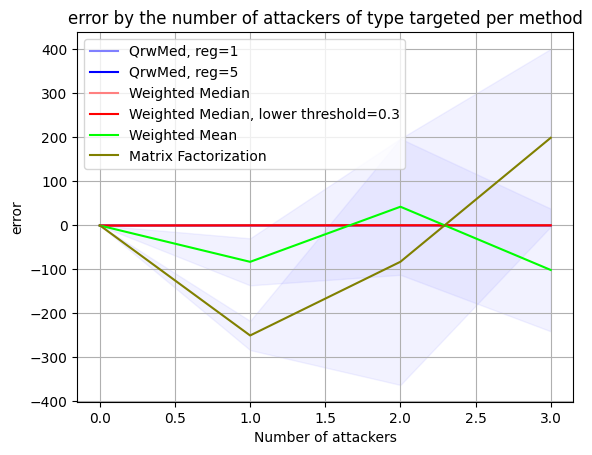

  0%|          | 0/4 [00:00<?, ?it/s]

2.3681043121490744
0.8388595807082565
1.7589194655870517
2.997589517397407
1.4899866077104478
1003.6546816747601
4.079778798152398
2005.0816526918752


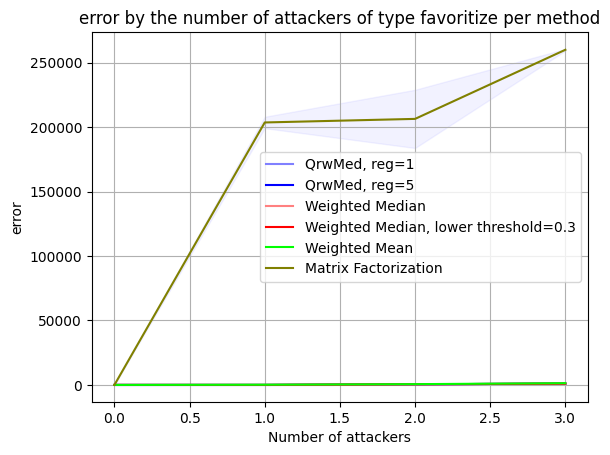

In [2]:
ax = plot_multiple_epochs(n_users=10, n_items=10, missing_prob=0.1, nb_attackers_to_test=np.arange(0, 4, 1),
                          error_func='error', nb_epochs=2, attackers_algo='random')
plt.show()
ax = plot_multiple_epochs(n_users=10, n_items=10, missing_prob=0.1, nb_attackers_to_test=np.arange(0, 4, 1),
                          error_func='error', nb_epochs=2, attackers_algo='targeted')
plt.show()
ax = plot_multiple_epochs(n_users=10, n_items=10, missing_prob=0.1, nb_attackers_to_test=np.arange(0, 4, 1),
                          error_func='error', nb_epochs=2, attackers_algo='favoritize')
plt.show()

Take matrix groundtruth

Add Nans

try to fill nans



Use spearman footrule

Mettre au propre

Identifier la meilleure coordonnée pour l'attaque et montrer à quel point ça marche mieux (ou baisser la densité)

## Performances loss

In [ ]:
n_users = 10
n_items = 5

ratings_df, long_df, meta = generate_synthetic_ratings(
        n_users=n_users,
        n_items=n_items,
        n_factors=6,
        n_groups=4,
        group_strength=0.1,
        user_noise=0.1,
        item_scale=0.1,
        user_bias_std=0.0,
        item_bias_std=0.0,
        global_mean=0.0,
        noise_std=0.05,
        rating_min=None,
        rating_max=None,
        random_seed=None
        )

#ratings_nans = inject_nans(ratings_df, 0.1, None)

qrwmed_reg5_error, qrwmed_reg0_error, med_thresh0_error, med_thresh03_error, mean_error, mf_error = compute_all_errors(ratings_df, nb_attackers=1, missing_prob=0.1)

plt.figure(figsize=(12,5))
plt.bar(['qrwmed_reg0','qrwmed_reg5','med_thresh0','med_thresh03','mean'], [qrwmed_reg5_error,qrwmed_reg0_error,med_thresh0_error,med_thresh03_error,mean_error,mf_error])

## Protection against random users

In [ ]:
n_users = 10
n_items = 5

ratings_df, long_df, meta = generate_synthetic_ratings(
        n_users=n_users,
        n_items=n_items,
        n_factors=6,
        n_groups=4,
        group_strength=0.1,
        user_noise=0.1,
        item_scale=0.1,
        user_bias_std=0.0,
        item_bias_std=0.0,
        global_mean=0.0,
        noise_std=0.05,
        rating_min=None,
        rating_max=None,
        random_seed=0
        )

for nb_attackers in np.arange(0, 11, 5):
    ratings_rand = inject_random_users(ratings_df, nb_attackers, 0)

    ratings_nans = inject_nans(ratings_df, 0.1, 0)

    qrwmed_reg5_error, qrwmed_reg0_error, med_thresh0_error, med_thresh03_error, mean_error, mf_error = compute_all_errors(ratings_nans)



  0%|          | 0/5 [00:00<?, ?it/s]

<AxesSubplot: title={'center': 'delta by the number of attackers per method'}, xlabel='Number of attackers', ylabel='delta'>

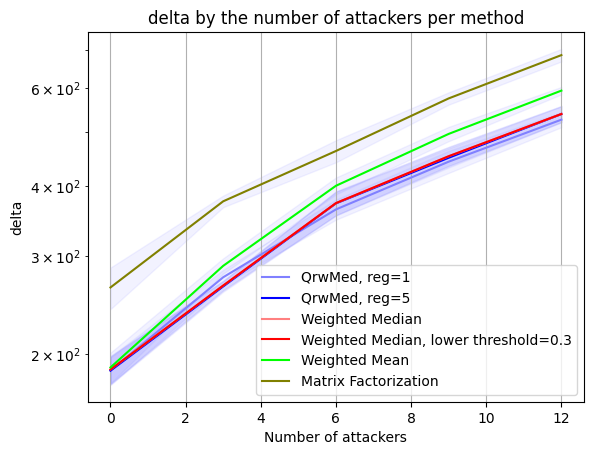

In [5]:
plot_multiple_epochs(500, 500, 0.8, np.arange(0, 15, 1), 'error', 10)

# Test Matrix Factorization

Finished epoch 0
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4


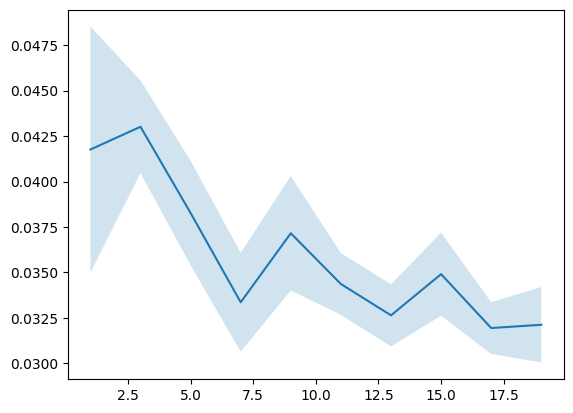

In [6]:
nb_epochs = 5
comp_to_test = range(1, 21, 2)

results = np.empty((nb_epochs, len(comp_to_test)))

for epoch in range(nb_epochs):

    ratings_df, long_df, meta = generate_synthetic_ratings(
                n_users=200,
                n_items=200,
                n_factors=5,
                n_groups=3,
                group_strength=0.1,
                user_noise=0.1,
                item_scale=0.1,
                user_bias_std=0.0,
                item_bias_std=0.0,
                global_mean=0.0,
                noise_std=0.05,
                rating_min=None,
                rating_max=None,
                random_seed=None
            )

    nans_ratings_df = inject_nans(ratings_df, 0.8, None)

    for id_comp, nb_components in enumerate(comp_to_test):

        inferred_df = infer_mf(nans_ratings_df, nb_components)
        results[epoch, id_comp] = np.mean((inferred_df-ratings_df)**2)
    print(f'Finished epoch {epoch}')

means = np.mean(results, axis=0)
plt.plot(comp_to_test, means)
plt.fill_between(comp_to_test, means + 1.96*(np.std(results, axis=0)/nb_epochs), means - 1.96*(np.std(results, axis=0)/nb_epochs), alpha=0.2)
plt.show()

Faire varier les autres paramètres

After: effect of sparcity, reg, lower_thresshold...

In [4]:
pmf = PMF(np.array(ratings_df), 15, learning_rate=0.01, reg_param=0.01, num_epochs=500, print_mse=True)

In [5]:
pmf.train()

Epoch: 1, MSE: 9.97558511479796
Epoch: 2, MSE: 9.969156142760712
Epoch: 3, MSE: 9.962789153868714
Epoch: 4, MSE: 9.95647412287826
Epoch: 5, MSE: 9.950201296040925
Epoch: 6, MSE: 9.943961160593483
Epoch: 7, MSE: 9.93774441621647
Epoch: 8, MSE: 9.931541948295731
Epoch: 9, MSE: 9.92534480284058
Epoch: 10, MSE: 9.91914416292984
Epoch: 11, MSE: 9.91293132657297
Epoch: 12, MSE: 9.90669768588835
Epoch: 13, MSE: 9.900434707514426
Epoch: 14, MSE: 9.894133914182147
Epoch: 15, MSE: 9.887786867389165
Epoch: 16, MSE: 9.881385151127583
Epoch: 17, MSE: 9.874920356627907
Epoch: 18, MSE: 9.868384068092316
Epoch: 19, MSE: 9.861767849400438
Epoch: 20, MSE: 9.855063231780834
Epoch: 21, MSE: 9.848261702451024
Epoch: 22, MSE: 9.841354694238696
Epoch: 23, MSE: 9.834333576206257
Epoch: 24, MSE: 9.827189645310613
Epoch: 25, MSE: 9.819914119139726
Epoch: 26, MSE: 9.812498129777277
Epoch: 27, MSE: 9.804932718856607
Epoch: 28, MSE: 9.797208833875077
Epoch: 29, MSE: 9.789317325849986
Epoch: 30, MSE: 9.781248948407